Long-range genomic language models identify extensive chimera artifacts in Nanopore direct RNA sequencing
Figure 1A, schematic of LLM

Figure 1B, simulation (internal and terminal), CNN, CNN+transformer, HyenaDNA

Figure 1C, real data VCaP002/VCaP004, detected chimeric reads when applying Dorado and Deepchopper, validation of chimeric read by direct cDNA, (Bar plot, Dorado trim, Dorado w/o trim, Deepchopper), 

Explain the coverage difference between true events and artifacts, we expect true events have higher coverage than false positive events, at least in RNA004 and PromethION data.

Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts. (possible in supplementary)

Figure 1G: other platforms, such as ONT cDNA(direct or PCR), R2C2, CapTrap etc. Testing this using H1 and WTC11 from ENCODE. Test if other platforms have less chimeric artifacts predicted by DeepChopper and reduced artifact reads almost cannot be validated by other platforms.
(https://www.encodeproject.org/matrix/?type=Experiment&control_type!=*&assay_term_name=long+read+RNA-seq&status=released)

Figure 2: A,B,C 
distribution of false positives across chr, 

gene expression and size distribution for those with artifacts. 
Gene GO enrichment suggests Ribosome and ChrM genes are frequently involved.

~~Figure 1J, gene rescue, including the chrM genes.~~

Figure 2D, gene fusion due to chimeric artifacts, highlighted by IGV and current signals, for example open pore signal, adapter feature signals!
Figure 2E: Count the percentage of Deepchopper splitted reads accounting for original chimeric reads and unmapped reads. Count how many of the unmapped reads can be remapped after deepchopper split. 

Could the relative (and/or absolute) coverage increase of genes ranked by these ratios or counts?

Figure 1 Supplementary
Terminal adapter quality, soft-clipping mapping comparison


In [53]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [54]:
import seaborn as sns
import json

In [55]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [56]:
from matplotlib import rcParams

# Set global font properties to Arial
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Arial",
        "pdf.fonttype": 42,  # Embed fonts as Type 3 fonts for compatibility
        "ps.fonttype": 42,
        "text.usetex": False,
        "svg.fonttype": "none",
    }
)

rcParams.update(
    {
        "font.size": 24,  # Set a default font size
        "legend.fontsize": 16,
        "legend.handlelength": 2,
        "axes.linewidth": 2,
    }
)


plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 16

In [57]:
# % colors
c1 = [i / 255 for i in (255, 200, 200)]
c2 = [i / 255 for i in (150, 220, 150)]
c3 = [i / 255 for i in (172, 188, 63)]

In [34]:
d1 = "#BF1D2D"
d2 = "#262626"
d3 = "#293890"

In [35]:
e1 = "#2F2D54"
e2 = "#9193B4"
e3 = "#BD9AAD"
e4 = "#E8D2B3"

# F1B  Simulation Result 

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# CNN 12 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9973070621490479     │
# │         test/loss         │   0.0006464940961450338   │
# │      test/precision       │    0.9969919919967651     │
# │        test/recall        │    0.9976223707199097     │
# └───────────────────────────┴───────────────────────────┘

# Hyena 120 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9930047988891602     │
# │         test/loss         │   0.0018698567291721702   │
# │      test/precision       │    0.9916011691093445     │
# │        test/recall        │    0.9944124817848206     │
# └───────────────────────────┴───────────────────────────┘

# CNN 120 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9906293749809265     │
# │         test/loss         │   0.0032503148540854454   │
# │      test/precision       │    0.9909157156944275     │
# │        test/recall        │    0.9903432130813599     │
# └───────────────────────────┴───────────────────────────┘


def simulation_plot(cl1, cl2, figsize=(6, 6), alpha=0.7, xlim=(0.8, 1), ylim=(0.8, 1)):
    cnn_name = "CNN"
    dc_name = "DeepChopper"

    data = {
        cnn_name: [0.9909157156944275, 0.9903432130813599],
        dc_name: [0.9916011691093445, 0.9944124817848206],
    }

    # Create a figure and axis
    _, ax = plt.subplots(figsize=figsize)

    # Define the F1 scores to plot
    f_scores = [0.2, 0.4, 0.6, 0.8, 0.9]

    # Initialize lists for lines and labels
    lines, labels = [], []

    # Plot F1 score iso-lines
    for f_score in f_scores:
        x = np.linspace(0.01, 1, 500)
        y = f_score * x / (2 * x - f_score)

        # Ensure y values are within [0, 1] range
        valid = (y >= 0) & (y <= 1)
        x = x[valid]
        y = y[valid]
        (l,) = plt.plot(x, y, color="gray", alpha=0.2, linewidth=3)

        # Add F1 score annotations
        plt.annotate(
            f"f1={f_score:0.1f}", xy=(0.9, f_score * 0.9 / (2 * 0.9 - f_score) + 0.02)
        )

    cnn_handle = plt.scatter(
        *data[cnn_name], c=cl1, s=120, label=cnn_name, alpha=alpha, edgecolors="none"
    )
    deepchopper_handle = plt.scatter(
        *data[dc_name], c=cl2, s=120, label=dc_name, alpha=alpha, edgecolors="none"
    )

    # # Add the scatter plots to handles
    handles = [cnn_handle, deepchopper_handle, l]
    labels = [cnn_name, dc_name, "Iso-f1 Curves"]
    plt.legend(handles=handles, labels=labels, loc="upper left")

    # Set the axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    sns.despine(offset=10, trim=True)
    # Label the plot
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    plt.tight_layout()
    plt.savefig("simulation_pr.pdf", dpi=300)

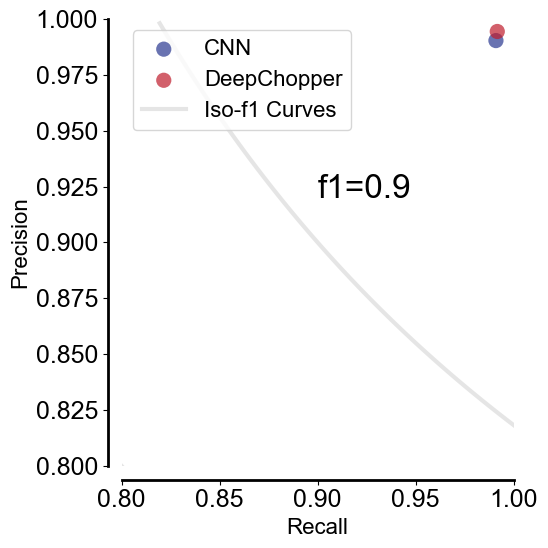

In [92]:
simulation_plot(d3, d1)

# F1C Bar PLot for Chemeric Read compare

In [69]:
type_names = ["Dorado with Trim", "Dorado w/o Trim", "DC"]

vcap002_data = {
    type_names[0]: [107266, 6228],
    type_names[1]: [107304, 6228],
    type_names[2]: [9844, 4664],
}

vcap004_data = {
    type_names[0]: [29144, 7165],
    type_names[1]: [29542, 7119],
    type_names[2]: [23044, 6440],
}


def prepare_data(data):
    data_with_validated = {
        "value": list(
            chain.from_iterable(
                [[data[t][0] - data[t][1], data[t][1]] for t in type_names]
            )
        ),
        "data type": list(chain.from_iterable([[i] * 2 for i in type_names])),
        "type": ["Unvalidated", "Validated"] * len(type_names),
    }
    data_df = pd.DataFrame(data_with_validated)
    return data_df

In [70]:
data_df = prepare_data(vcap002_data)
vcap004_data_df = prepare_data(vcap004_data)

In [71]:
data_df

,value,data type,type
0,101038,Dorado with Trim,Unvalidated
1,6228,Dorado with Trim,Validated
2,101076,Dorado w/o Trim,Unvalidated
3,6228,Dorado w/o Trim,Validated
4,5180,DC,Unvalidated
5,4664,DC,Validated


Text(0, 0.5, 'Count')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Data  Type')

Text(0.5, 0, 'Data  Type')

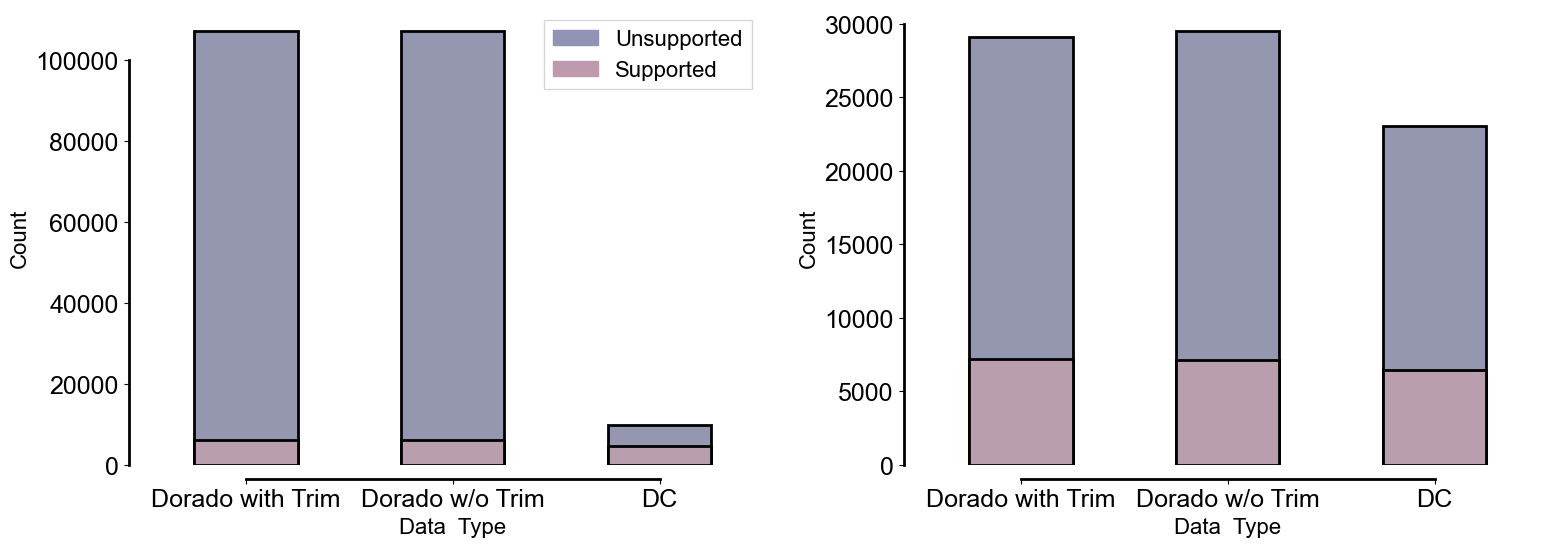

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
axs = axs.flatten()

bar_width = 0.5

bar1 = sns.barplot(
    data=data_df.groupby("data type")["value"].sum().reset_index(),
    x="data type",
    y="value",
    order=type_names,
    color=e2,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[0],
)
bar2 = sns.barplot(
    data=data_df.query("type == 'Validated'"),
    x="data type",
    y="value",
    order=type_names,
    estimator=sum,
    color=e3,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[0],
)


bar3 = sns.barplot(
    data=vcap004_data_df.groupby("data type")["value"].sum().reset_index(),
    x="data type",
    y="value",
    order=type_names,
    color=e2,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[1],
)
bar4 = sns.barplot(
    data=vcap004_data_df.query("type == 'Validated'"),
    x="data type",
    y="value",
    order=type_names,
    estimator=sum,
    color=e3,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[1],
)


# add legend
top_bar = mpatches.Patch(color=e2, label="Unsupported")
bottom_bar = mpatches.Patch(color=e3, label="Supported")
axs[0].legend(handles=[top_bar, bottom_bar], fancybox=False)

sns.despine(offset=10, trim=True)

axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")

axs[0].set_xlabel("Data  Type")
axs[1].set_xlabel("Data  Type")

plt.tight_layout()
plt.savefig("bar_plot_chemeric_read_cmp.pdf", dpi=300)

In [92]:
# Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts

# F1D BLAT for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [77]:
import json

In [78]:
# load data
plot_data = json.load(open("data/internal_prediction_seq_blat_top1_indentities.json"))
plot_data_vcap_004 = json.load(
    open("data/fp_vcap_004_hyena_all_predicts_blat_identities.json")
)

In [79]:
len(plot_data)

98807

In [80]:
len(plot_data_vcap_004)

6185

<Figure size 700x600 with 0 Axes>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0.5, 0, 'BLAT Indentity')

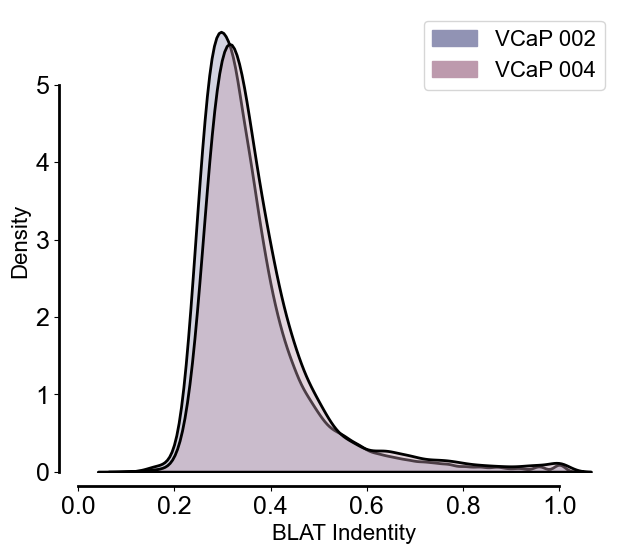

In [81]:
plt.figure(figsize=(7, 6))
sns.kdeplot(data=plot_data, fill=True, color=e2, edgecolor="k", linewidth=2, alpha=0.4)
sns.kdeplot(
    data=plot_data_vcap_004, fill=True, color=e3, edgecolor="k", linewidth=2, alpha=0.4
)

left_bar = mpatches.Patch(color=e2, label="VCaP 002")
right_bar = mpatches.Patch(color=e3, label="VCaP 004")
plt.legend(handles=[left_bar, right_bar], loc="upper right")

sns.despine(offset=10, trim=True)
plt.xlabel("BLAT Indentity")
# plt.ylabel("Density")
plt.savefig(
    "blat_for_fp_internal_prediction_cmp_with_dorado.pdf", bbox_inches="tight", dpi=300
)

# F1E Base Quals for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [94]:
import json

In [95]:
def plot_qual(file_path):
    from needletail import parse_fastx_file

    quals = []
    for record in parse_fastx_file(file_path):
        current_quals = [ord(i) - 33 for i in list(record.qual)]
        quals.append(sum(current_quals) / len(current_quals))
    return quals

In [96]:
# load data
plot_data = [
    i - 33 for i in json.load(open("data/internal_prediction_seq_base_quals.json"))
]
# load data
plot_qual_left_seq_data = plot_qual("./data/fp_dorado_hyena_vcap_002.fq.gz")

In [97]:
len(plot_qual_left_seq_data)

181161

In [98]:
len(plot_data)

146580

In [99]:
vcap_004_plot_data = [
    i - 33 for i in json.load(open("data/fp_vcap_004_hyena_predicts_base_quals.json"))
]
vcap_plot_qual_left_seq_data = plot_qual("./data/fp_dorado_hyena_vcap_004.fq.gz")

In [100]:
len(vcap_plot_qual_left_seq_data)

13602

In [101]:
len(vcap_004_plot_data)

11143

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0.5, 0, 'Base Qual')

Text(0.5, 0, 'Base Qual')

Text(0, 0.5, 'Density')

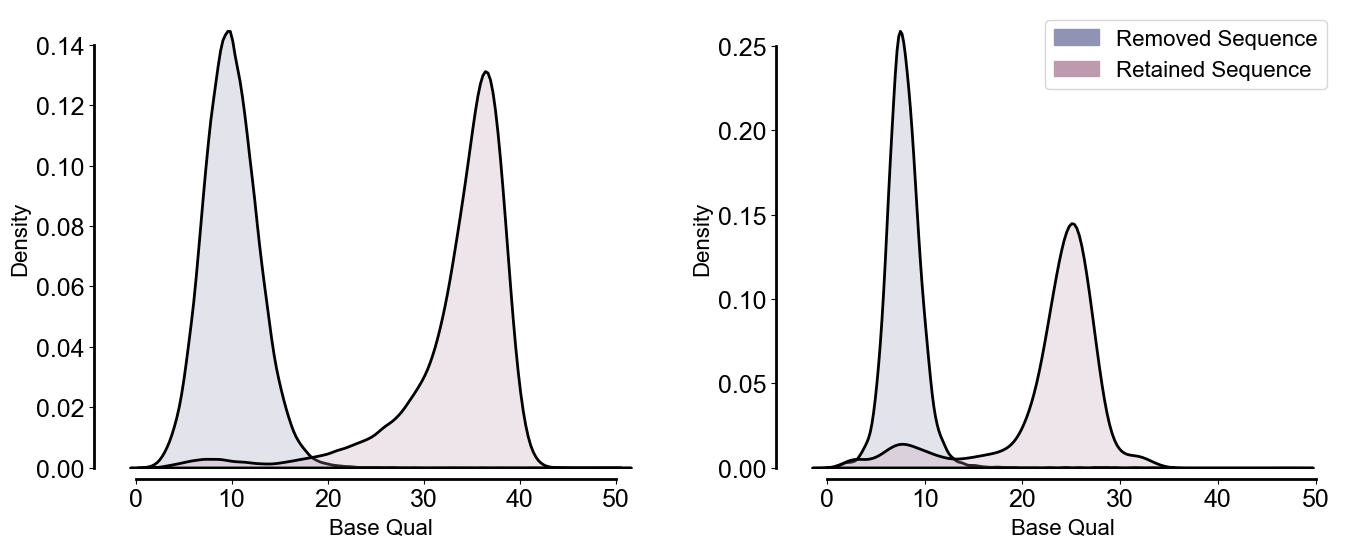

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
axs = axs.flatten()

sns.kdeplot(data=plot_data, fill=True, color=e2, edgecolor="k", linewidth=2, ax=axs[0])
sns.kdeplot(
    data=plot_qual_left_seq_data,
    fill=True,
    color=e3,
    edgecolor="k",
    linewidth=2,
    ax=axs[0],
)

sns.kdeplot(
    data=vcap_004_plot_data, fill=True, color=e2, edgecolor="k", linewidth=2, ax=axs[1]
)
sns.kdeplot(
    data=vcap_plot_qual_left_seq_data,
    fill=True,
    color=e3,
    edgecolor="k",
    linewidth=2,
    ax=axs[1],
)

left_bar = mpatches.Patch(color=e2, label="Removed Sequence")
right_bar = mpatches.Patch(color=e3, label="Retained Sequence")
axs[1].legend(handles=[left_bar, right_bar], loc="best")

sns.despine(offset=8, trim=True)

axs[0].set_xlabel("Base Qual")
axs[1].set_xlabel("Base Qual")
plt.ylabel("Density")


plt.tight_layout()

# fig.subplots_adjust(wspace=0.1)

plt.savefig(
    "base_quals_for_fp_internal_prediction_cmp_with_dorado.pdf",
    bbox_inches="tight",
    dpi=300,
)

# distribution of false positives across chr

## Vcap 002  

In [ ]:
# [2024-07-17T15:42:11Z INFO  internal] Total number of reads: 175094
# [2024-07-17T15:42:11Z INFO  internal] Number of reads with SA tag: 869
# [2024-07-17T15:42:11Z INFO  internal] Number of reads without SA tag: 174225
# [2024-07-17T15:42:11Z INFO  internal] Summary saved to sa_summary.json
# [2024-07-17T15:42:11Z INFO  internal] elapsed time: 666.45ms

In [1]:
import pysam
import json

In [19]:
samfile  = pysam.AlignmentFile("data/fp_dorado_hyena_vcap_002.bam", "rb")

# len([1 for read in samfile.fetch() if read.is_mapped and not read.is_secondary and not read.is_supplementary])

# len([1 for read in samfile.fetch() if not read.is_mapped])

# for read in samfile.fetch():
#     if read.is_unmapped:
#         print(read)

In [28]:
# read_ids = [read.query_name for read in samfile.fetch()]
for read in samfile.fetch():
    if read.query_name == "a08a11cf-887d-4279-8724-26fafa1abcf5":
        print(read.reference_name, read.mapping_quality, read.is_mapped)
        if read.has_tag("SA") and not read.is_secondary and not read.is_supplementary:
            print(read.get_tag("SA"))
        # print(read)

chr10 38 True
chr11 60 True
chr6 0 True
chr6 0 True
chr8 60 True
chr11,46428626,-,82S506M21D941S,60,97;chr10,124490384,-,390S297M13240D842S,38,83;


In [29]:
vcap002_sa_tag_summary_path = "data/fp_dorado_hyena_vcap_002_do_sa_summary.json"
vcap002_sa_tag_summary = json.load(open(vcap002_sa_tag_summary_path))

In [30]:
len(vcap002_sa_tag_summary)

88164

In [35]:
vcap002_sa_tag_summary

{'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5:181236937', 'chr19:36115547'],
 '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19:13153095', 'chr8:108201743'],
 '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8:133237175',
  'chr19_GL949748v2_alt:176140'],
 'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11:66638705', 'chr19:48615331'],
 'd3e5f061-df93-4223-802a-8d6b676018f7': ['chr6_GL000254v2_alt:4708052',
  'chr5:132866652'],
 '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19:48795066', 'chr17:82078343'],
 'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12:14881893', 'chr2:101002702'],
 'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12:6965352', 'chr19:50878632'],
 'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3:64010566', 'chr19:12943610'],
 'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8:42541631', 'chr1:6186220'],
 '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM:3316', 'chr2:216499269'],
 'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9:5357960', 'chr11:63759674'],
 'fc0dc82f-983b-4980-b158-3cd7e902

In [36]:
all_chrs = [f"chr{i}" for i in range(1, 23)]  + ["chrM", "chrX", "chrY", 'alt']
all_chrs_index = {v: i  for i,v in enumerate(all_chrs)}

In [13]:
from collections import defaultdict

def filter_data(data):
    filtered_data = defaultdict(list)
    for k, vs in data.items():
        name = k
        filtered_data[name].append((k, vs[0]))
        
    return filtered_data

In [38]:
# filter_vcap002_sa_tag_summary = filter_data(vcap002_sa_tag_summary)

In [21]:
def sort_value(value):
    return int(value[0].split("|")[1].split(":")[0])

In [40]:
def extract_chr(sa_summary_connection, all_chrs):
    result = defaultdict(list)

    for k, vs in sa_summary_connection.items():
        cleaned_vs = []
        for v in vs:
            chr_name = v.split(":")[0]
            if chr_name not in all_chrs:
                chr_name = "alt"
            cleaned_vs.append(chr_name)

        result[k] = cleaned_vs

    return result

In [41]:
vcap002_sa_tag_summary_connection_chr = extract_chr(vcap002_sa_tag_summary, all_chrs)

In [42]:
vcap002_sa_tag_summary_connection_chr

defaultdict(list,
            {'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5', 'chr19'],
             '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19', 'chr8'],
             '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8', 'alt'],
             'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11', 'chr19'],
             'd3e5f061-df93-4223-802a-8d6b676018f7': ['alt', 'chr5'],
             '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19', 'chr17'],
             'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12', 'chr2'],
             'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12', 'chr19'],
             'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3', 'chr19'],
             'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8', 'chr1'],
             '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM', 'chr2'],
             'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9', 'chr11'],
             'fc0dc82f-983b-4980-b158-3cd7e902a5ce': ['chr17', 'chr21'],
             'e6f7d025-de6e-4ede-a064-eaa4b77236

In [43]:
len(vcap002_sa_tag_summary_connection_chr)

88164

In [44]:
for k, v in vcap002_sa_tag_summary_connection_chr.items():
    if len(v) > 2:
        print(k, v)

In [45]:
vcap002_sa_tag_summary_connection_chr

defaultdict(list,
            {'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5', 'chr19'],
             '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19', 'chr8'],
             '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8', 'alt'],
             'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11', 'chr19'],
             'd3e5f061-df93-4223-802a-8d6b676018f7': ['alt', 'chr5'],
             '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19', 'chr17'],
             'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12', 'chr2'],
             'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12', 'chr19'],
             'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3', 'chr19'],
             'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8', 'chr1'],
             '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM', 'chr2'],
             'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9', 'chr11'],
             'fc0dc82f-983b-4980-b158-3cd7e902a5ce': ['chr17', 'chr21'],
             'e6f7d025-de6e-4ede-a064-eaa4b77236

In [46]:
all_chrs_index

{'chr1': 0,
 'chr2': 1,
 'chr3': 2,
 'chr4': 3,
 'chr5': 4,
 'chr6': 5,
 'chr7': 6,
 'chr8': 7,
 'chr9': 8,
 'chr10': 9,
 'chr11': 10,
 'chr12': 11,
 'chr13': 12,
 'chr14': 13,
 'chr15': 14,
 'chr16': 15,
 'chr17': 16,
 'chr18': 17,
 'chr19': 18,
 'chr20': 19,
 'chr21': 20,
 'chr22': 21,
 'chrM': 22,
 'chrX': 23,
 'chrY': 24,
 'alt': 25}

In [47]:
def process_dorado_trim_sa_reads(sa_tag_summary, chrs, all_chr_index):
    matrix_plot = pd.DataFrame(np.zeros((len(chrs), len(chrs))),  columns=chrs,  index=chrs)
    
    for k, v in sa_tag_summary.items():        
        assert len(v) == 2 
        
        c1 = v[0]
        c2 = v[1]
        
            
        if "_" in c1:
            c1 = "alt"
            
        if "_" in c2:
            c2 = "alt"

        c1_index = all_chr_index[c1]
        c2_index = all_chr_index[c2] 

        if c1_index > c2_index:
            c1_index,c2_index = c2_index,c1_index
        
        matrix_plot.iloc[c1_index, c2_index] +=1 

    return matrix_plot

In [50]:
import pandas as pd
import numpy as np

matrix_data  = process_dorado_trim_sa_reads(vcap002_sa_tag_summary_connection_chr, all_chrs, all_chrs_index)

In [51]:
matrix_data

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY,alt
chr1,458.0,617.0,666.0,349.0,470.0,664.0,379.0,465.0,607.0,405.0,...,781.0,130.0,1245.0,235.0,122.0,241.0,434.0,335.0,28.0,436.0
chr2,0.0,212.0,505.0,252.0,325.0,517.0,264.0,293.0,364.0,258.0,...,562.0,81.0,872.0,182.0,86.0,176.0,303.0,197.0,20.0,289.0
chr3,0.0,0.0,287.0,300.0,394.0,521.0,304.0,330.0,432.0,303.0,...,590.0,99.0,967.0,198.0,113.0,212.0,310.0,267.0,19.0,354.0
chr4,0.0,0.0,0.0,60.0,172.0,258.0,158.0,162.0,227.0,128.0,...,316.0,40.0,472.0,110.0,44.0,82.0,172.0,107.0,12.0,170.0
chr5,0.0,0.0,0.0,0.0,141.0,364.0,220.0,251.0,320.0,179.0,...,452.0,52.0,659.0,133.0,69.0,128.0,232.0,179.0,10.0,196.0
chr6,0.0,0.0,0.0,0.0,0.0,205.0,348.0,337.0,410.0,258.0,...,634.0,77.0,819.0,160.0,124.0,173.0,302.0,236.0,24.0,314.0
chr7,0.0,0.0,0.0,0.0,0.0,0.0,97.0,201.0,268.0,157.0,...,355.0,47.0,513.0,106.0,63.0,96.0,202.0,145.0,16.0,186.0
chr8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,273.0,190.0,...,450.0,69.0,641.0,146.0,67.0,115.0,222.0,162.0,14.0,195.0
chr9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.0,241.0,...,477.0,63.0,703.0,158.0,76.0,169.0,258.0,221.0,17.0,248.0
chr10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,...,301.0,55.0,512.0,119.0,60.0,105.0,182.0,132.0,8.0,172.0


<Axes: >

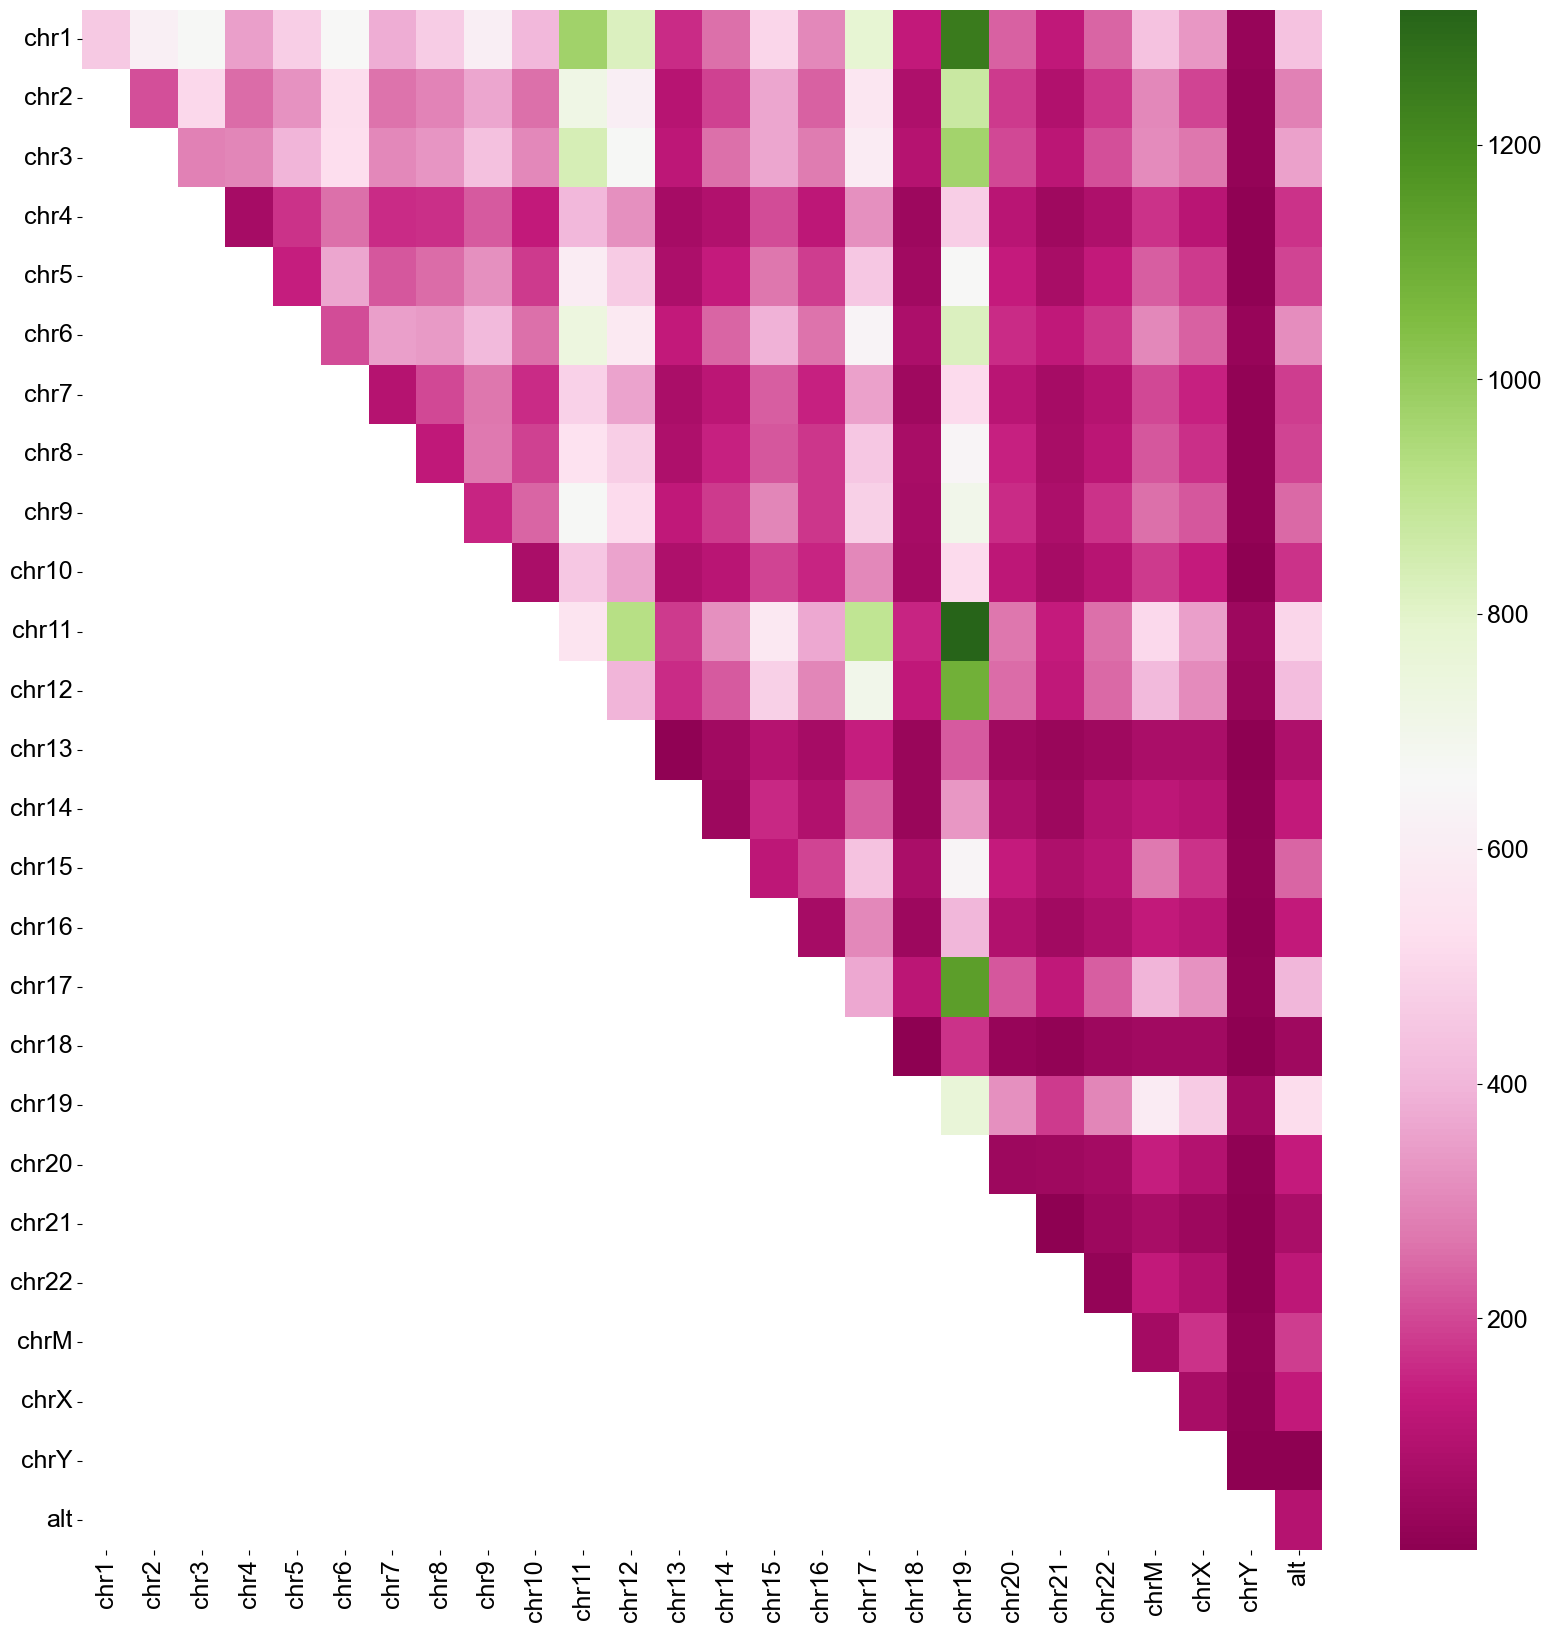

In [59]:
data = matrix_data
fig, ax1 = plt.subplots(figsize=(20, 20))
mask = np.zeros_like(data)
mask[np.tril_indices_from(mask, k=-1)] = True
sns.heatmap(data, mask=mask, cmap="PiYG")

In [149]:
# all_chrs_labels = [f"Chr {i}" for i in range(1, 23)]  + ["Chr M", "Chr X", "Chr Y"]
all_chrs_labels = [f"{i}" for i in range(1, 23)]  + ["M", "X", "Y"]

In [150]:
colors = [ 
"#227980",
"#688F69",
"#D2DC38",
"#F5B16E",
"#F38F3C",
"#CE9FCA",

"#FAE93B",
"#415C42",
"#F7D1E3",
"#734E9C",
"#A9CCDE",
"#707070",

"#8BB8D6",
"#F7BF6C",
"#C0845C",
"#61B673", 
"#F37F76",
"#C3b0D2",

"#D4242A",
"#EE9094",
"#BCD896",
"#C6C2DF",
"#0C0C0C",
"#90D0C2",

"#FFCFD1"
]

all_chrs_colors = {l: colors[ind] for ind, l in enumerate(all_chrs_labels)}

In [151]:
all_chrs_colors

{'1': '#227980',
 '2': '#688F69',
 '3': '#D2DC38',
 '4': '#F5B16E',
 '5': '#F38F3C',
 '6': '#CE9FCA',
 '7': '#FAE93B',
 '8': '#415C42',
 '9': '#F7D1E3',
 '10': '#734E9C',
 '11': '#A9CCDE',
 '12': '#707070',
 '13': '#8BB8D6',
 '14': '#F7BF6C',
 '15': '#C0845C',
 '16': '#61B673',
 '17': '#F37F76',
 '18': '#C3b0D2',
 '19': '#D4242A',
 '20': '#EE9094',
 '21': '#BCD896',
 '22': '#C6C2DF',
 'M': '#0C0C0C',
 'X': '#90D0C2',
 'Y': '#FFCFD1'}

In [152]:
len(colors)

25

In [153]:
# all_chrs_labels
selected_matrix = matrix_data.iloc[:25, :25]
selected_matrix.index = all_chrs_labels 
selected_matrix.columns = all_chrs_labels

In [ ]:
from pycirclize import Circos

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
selected_matrix,
    space=1,
    r_lim=(93, 100),
    cmap=all_chrs_colors,
    label_kws=dict(size=16),
    link_kws=dict(ec="black", lw=0, direction=0, alpha=0.6, color="white"),
)


fig = circos.plotfig(dpi=300, 
# figsize=(10, 10)
)
plt.tight_layout()
fig.savefig("vcap002_sa_tag_summary_connection_chr.pdf", dpi=300)

# Supplemental Figures